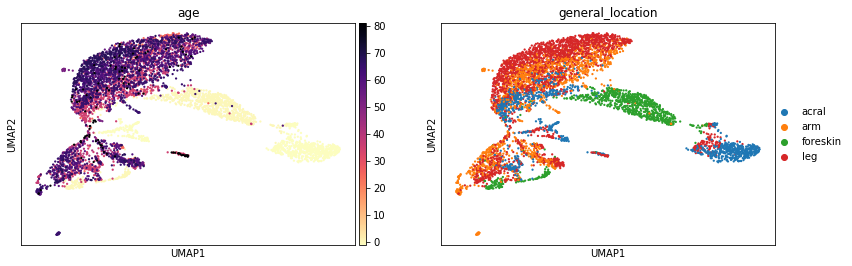

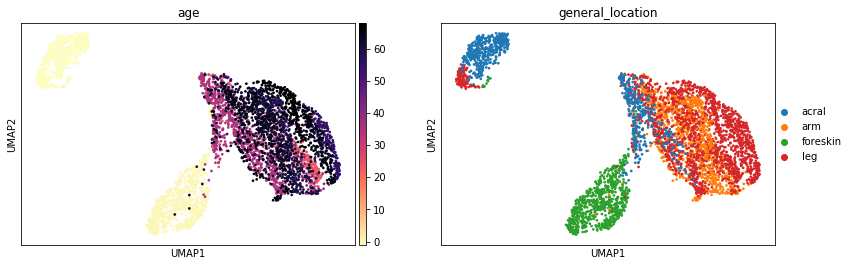

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT', 'raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


In [2]:
%%capture
###############################################
###############################################
# Classify acral vs. cutaneous vs. foreskin cells
# This chunk updates input adata
###############################################
###############################################

patient2feature = {'12WKM01':'0',
                   'A1038LM':'1'}

input_adata = adata_subset2

rank_groupby = 'louvain'
rank_ngenes = 20

###############################################

ranks_dict = {}
for patientOI, value in patient2feature.items():
    exec(f'global adata_{patientOI}')
    input_adata = adata_subset2
    patients = list(set(input_adata.obs.patient))
    type_dict = {'in':[patientOI],
                 'out':[x for x in patients if x != patientOI]}

    classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_3')

    feature_dict = {'class_3':['in']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)
    sc.pl.umap(adata_subset3, color=['louvain','general_location'])
    
    exec(f'adata_{patientOI} = input_adata = adata_subset3')
    ranks_df = simple_rank (input_adata, groupby=rank_groupby, n_genes=rank_ngenes)
    ranks_df['patient'] = patientOI
    ranks_dict[patientOI] = ranks_df

### Need to classify cell type to disambigueate mixed populations in general location
# extract cell id from individual patients with acral
# rely on louvain clustering to annotate cell type

acral_cells_list = []
for key,value in patient2feature.items():
    acral_slice = eval(f'adata_{key}.obs.reset_index().loc[:,["index","louvain"]]')
    acral_slice = acral_slice[acral_slice.louvain == patient2feature[key]]
    acral_cells = acral_slice['index'].values.tolist()
    acral_cells_list= acral_cells_list + acral_cells

# create cell type labels: cut, fsk, acr
adata_subset2.obs['cell_type'] = ['fsk' if x == 'foreskin' else 'cut' for x in adata_subset2.obs.general_location]
adata_subset2.obs['cell_type'] = ['acr' if x in acral_cells_list else y for x,y in zip(adata_subset2.obs.index,
                                                                                       adata_subset2.obs.cell_type)]


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical


acr
   PC        f1
0   1  0.000000
1   2  0.712788
2   3  0.000000
3   4  0.000000
4   5  0.007812
5   6  0.007782
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.000000


... storing 'cell_type' as categorical


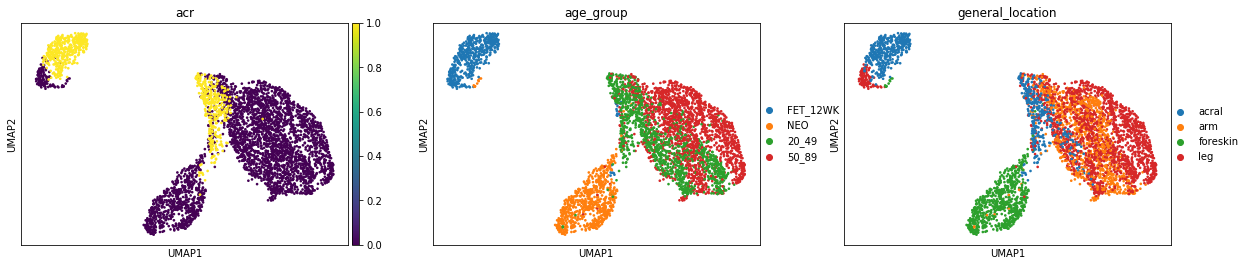

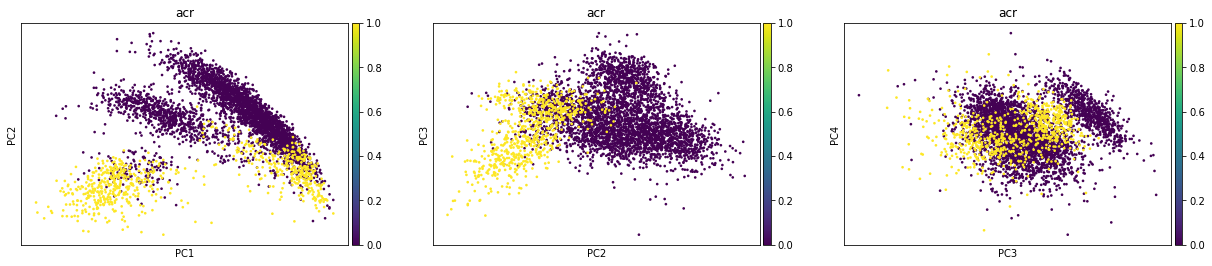

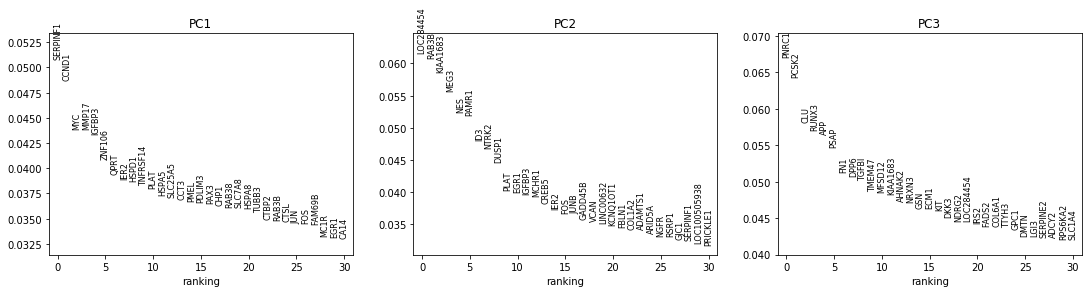

fsk
   PC        f1
0   1  0.088154
1   2  0.000000
2   3  0.812095
3   4  0.250825
4   5  0.000000
5   6  0.000000
6   7  0.000000
7   8  0.000000
8   9  0.000000
9  10  0.008097


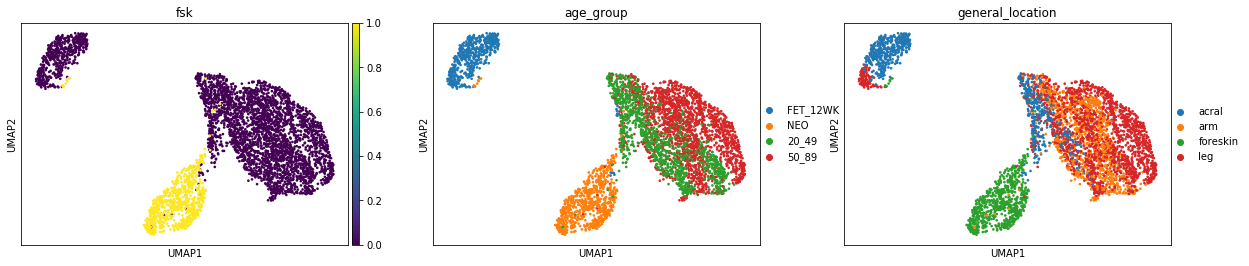

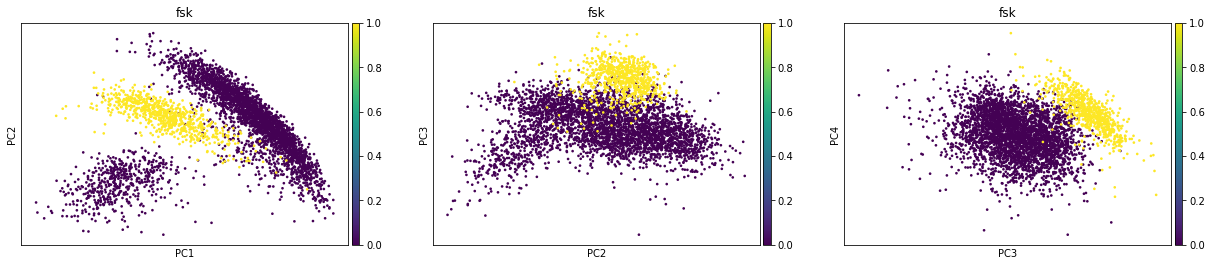

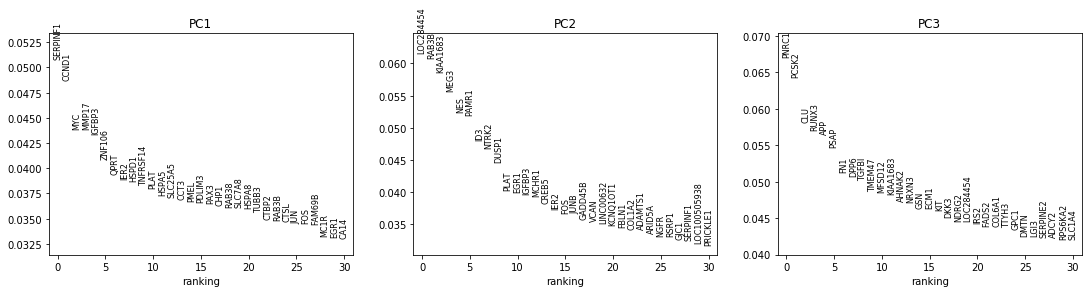

In [3]:
# determine which pc coordinate set best recalls general location label
input_adata = adata_subset2
pca_genes_df = pd.DataFrame()

for groupby in ['acr', 'fsk']:
    print(groupby)
    input_adata.obs[groupby] = [x in [groupby] for x in input_adata.obs['cell_type'].values]

    results_list = []
    cell_list = input_adata.obs_names
    loc_list = input_adata.obs[groupby].values
    for PC in range(input_adata.obsm['X_pca'].shape[1]):
        PC_list = input_adata.obsm['X_pca'][:,PC]

        pred = PC_list # must be continuous
        res = np.array(loc_list) # must be categorical
        pred = pred.reshape(-1,1)
        res = res.reshape(-1,1)

        if len(np.unique(res)) == 1:
            acc = 0
        else:
            X_train, X_test, y_train, y_test = train_test_split(pred,
                                                                res,
                                                                test_size=0.33, 
                                                                random_state=42)
            # accurcy
            clf = LogisticRegression(multi_class='auto')
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc  = f1_score(y_true = y_test, 
                            y_pred = y_pred, 
                            average = 'binary')

            results_list.append(acc)
    print(pd.DataFrame({'PC':[x+1 for x in range(len(results_list))],
                  'f1':results_list}).head(10))

    sc.pl.umap(input_adata, color=[groupby,'age_group','general_location'])
    sc.pl.pca(input_adata, components=['1,2','2,3','3,4'], color=[groupby])
    sc.pl.pca_loadings(input_adata)
    
    # extract gene names from loadings
    ## top10 and bottom10 genes for top10 PCs
    for idx in range(10):
        pc_idx = idx

        pc_genes = (pd.DataFrame({'genes': input_adata.var_names.tolist(),
                                  'loadings': input_adata.varm['PCs'][:,pc_idx]})
                   .sort_values('loadings'))
        pc_genes['pc_idx'] = pc_idx
        pc_genes['idx'] = [x for x in range(len(pc_genes))]
        pc_genes['groupby'] = groupby
        pca_genes_df = pca_genes_df.append(pc_genes.head(10))
        pca_genes_df = pca_genes_df.append(pc_genes.tail(10))
        

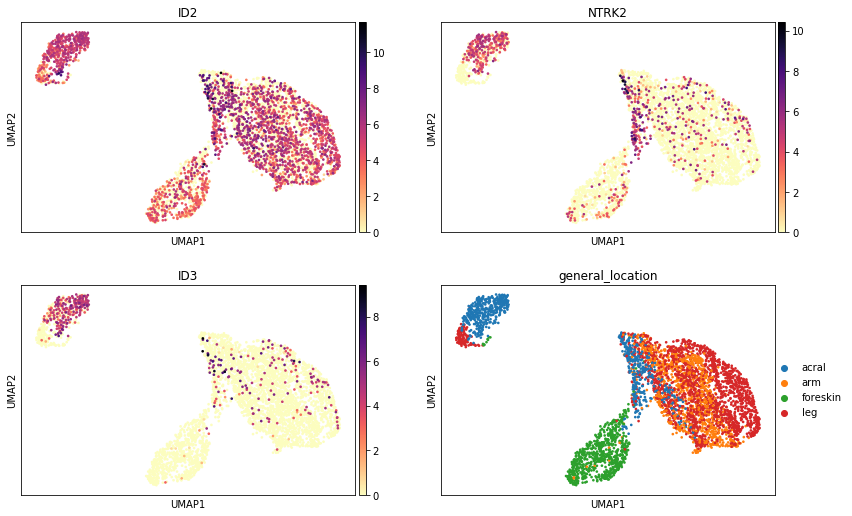

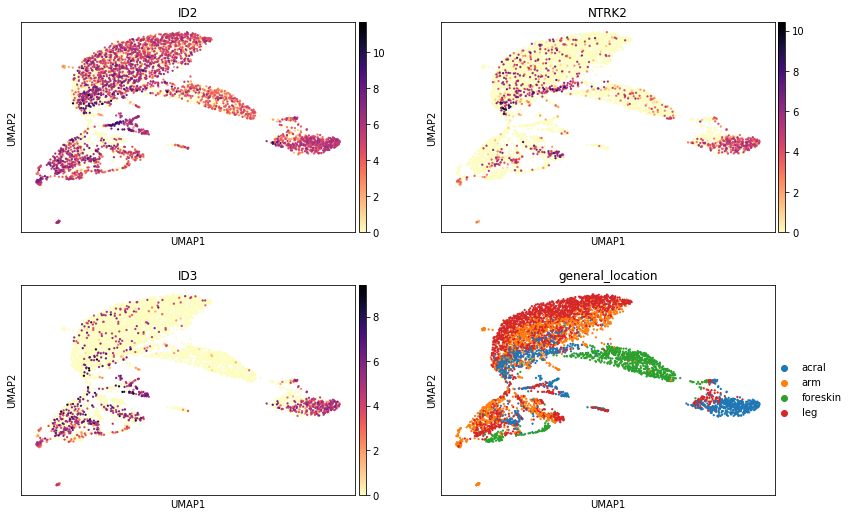

querying 1-3...done.
Finished.
0: ID2
The protein encoded by this gene belongs to the inhibitor of DNA binding family, members of which are transcriptional regulators that contain a helix-loop-helix (HLH) domain but not a basic domain. Members of the inhibitor of DNA binding family inhibit the functions of basic helix-loop-helix transcription factors in a dominant-negative manner by suppressing their heterodimerization partners through the HLH domains. This protein may play a role in negatively regulating cell differentiation. A pseudogene of this gene is located on chromosome 3. [provided by RefSeq, Aug 2011].
1: NTRK2
This gene encodes a member of the neurotrophic tyrosine receptor kinase (NTRK) family. This kinase is a membrane-bound receptor that, upon neurotrophin binding, phosphorylates itself and members of the MAPK pathway. Signalling through this kinase leads to cell differentiation. Mutations in this gene have been associated with obesity and mood disorders. Alternative splic

In [4]:
###############################################
###############################################
# Display summary of DE genes found in all samples
# This chuck displays MEL and all-cells UMAPS and gene annotations
###############################################
###############################################

# Specify patients and feature group
patient2feature = {'12WKM01':'0',
                   'A1038LM':'1'}

###############################################

full_list = []
for key,value in patient2feature.items():
    list_iter = list(set(ranks_dict[key][value].values.tolist()))
    full_list = full_list + list_iter

union_df = pd.DataFrame({'genes':full_list})['genes'].value_counts()
genes = union_df[union_df > 1].index.tolist()
sc.pl.umap(adata_subset2, color=genes+['general_location'], ncols = 2, cmap='magma_r')
sc.pl.umap(full_adata, color=genes+['general_location'], ncols = 2, cmap='magma_r')
out = symbol2field(genes)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

In [5]:


# fetal vs not
## compare to similar mouse studies

# foreskin vs not

# Look at adt mel outliers to see if there is correlation to fetal expression


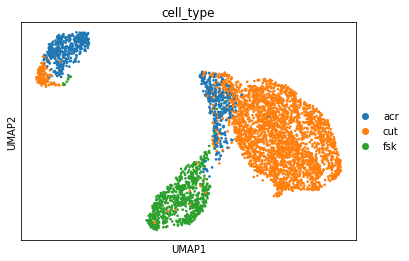

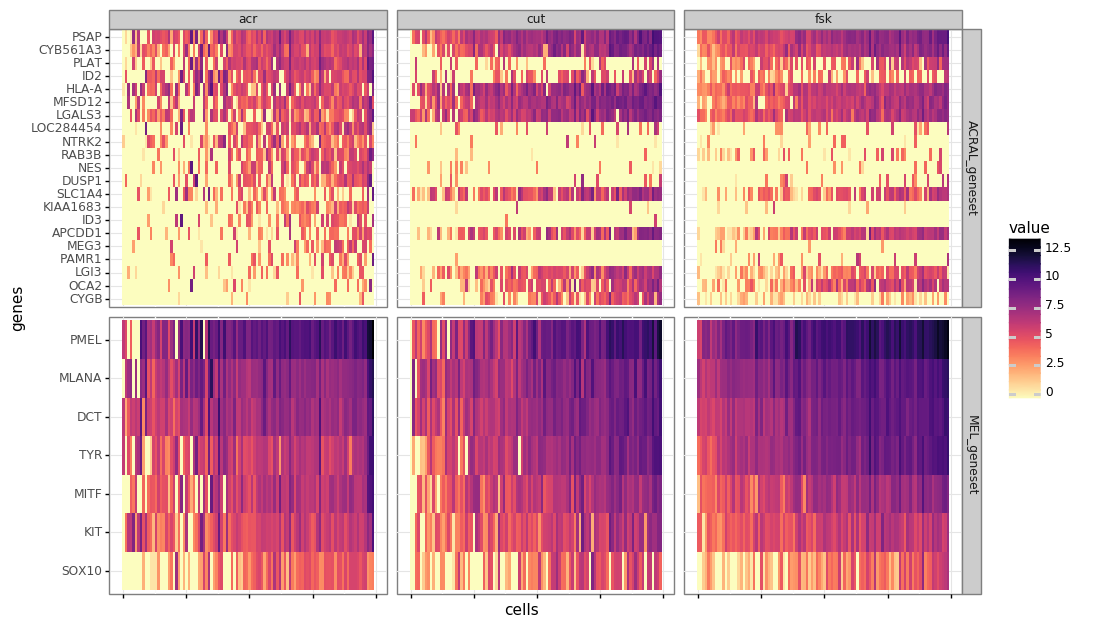

<ggplot: (-9223363244591668711)>


In [6]:
# heat map of Acral vs rest
input_adata = adata_subset2
sc.pl.umap(input_adata, color=['cell_type'], cmap = 'magma_r')
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
groupby_var = 'acr'
cell_groups = 'cell_type'
pcOIs = [1]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':genes+pc_genes+canonical_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()

subsampled_patients = []
for label in list(set(input_adata.obs[cell_groups])):
    subsampled_patients = subsampled_patients + (input_adata[input_adata.obs[cell_groups] == label]
                                                      .obs.sample(100)
                                                      .index
                                                      .tolist())

subsampled_df = input_adata[[x in subsampled_patients for x in input_adata.obs.index]]
cat, genesOI_df = prepare_dataframe(subsampled_df,
                                var_names = genelist,
                              groupby=cell_groups)  
genesOI_df = genesOI_df.reset_index().sort_values(cell_groups)
genesOI_df_reindex = pd.DataFrame()
for label in list(set(genesOI_df[cell_groups])):
    genesOI_slice = genesOI_df[genesOI_df[cell_groups] == label]
    genesOI_slice['row_mean'] = genesOI_slice.mean(axis = 1)
    genesOI_slice = genesOI_slice.sort_values('row_mean')
    genesOI_slice['index'] = [x for x in range(len(genesOI_slice))]
    genesOI_df_reindex = genesOI_df_reindex.append(genesOI_slice.drop('row_mean', axis = 1))

plot_df = pd.melt(genesOI_df_reindex, id_vars=[cell_groups,'index'])
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))

plotnine.options.figure_size = (11,11)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank(),
            aspect_ratio = 1)
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'group~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))


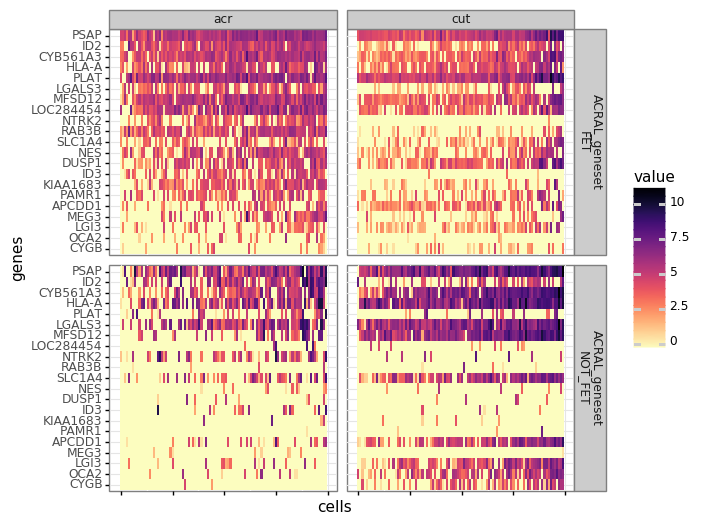

<ggplot: (8792157029366)>


In [11]:
### (Fet vs non-fet age) by (acral vs leg location)

# heat map
input_adata = adata_subset2
input_adata.obs['age_label'] = ['FET' if x == 'FET_12WK' else 'NOT_FET' for x in input_adata.obs['age_group']]
input_adata.obs['age_label'] = input_adata.obs['age_label'].astype(str).astype(CategoricalDtype(['FET','NOT_FET']))
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
genes = ['NTRK2', 'ID2', 'ID3'] # from wilcoxon / t-test DE genes lists
groupby_var = 'acr'
cell_groups = 'cell_type'
pcOIs = [1]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':genes+pc_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()
return_df = pd.DataFrame()

for label in ['acr','cut']: # cell type
    for group in ['FET','NOT_FET']:
        slice_df = input_adata[[x == label and y == group for x,y in zip(input_adata.obs[cell_groups], 
                                                                         input_adata.obs.age_label)]]
        cells2keep = slice_df.obs.sample(100).index.tolist()
        slice_df = slice_df[[x in cells2keep for x in slice_df.obs.index.tolist()]]
        cat, genesOI_df = prepare_dataframe(slice_df,
                                            var_names = genelist,
                                            groupby='age_label')  
        genesOI_df = genesOI_df.reset_index() # recover groupby label
        genesOI_df[cell_groups] = label
        genesOI_df['row_mean'] = genesOI_df.mean(axis = 1)
        genesOI_df = genesOI_df.sort_values('row_mean')
        genesOI_df['index'] = [x for x in range(len(genesOI_df))]
        return_df = return_df.append(genesOI_df.drop('row_mean', axis = 1))

plot_df = pd.melt(return_df, id_vars=['index','age_label',cell_groups])
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))
plot_df['group'] = ['MEL_geneset' if x in canonical_genes else 'ACRAL_geneset' for x in plot_df.variable]

plotnine.options.figure_size = (6,6)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank())
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'age_label+group~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))

In [8]:
%%capture

# cluster with 2 acral samples + 1 fskin
patientOIs = ['12WKM01', 'A1038LM', 'FS030_LM', 'FS043_LM']

input_adata = adata_subset2
patients = list(set(input_adata.obs.patient))
type_dict = {'in':patientOIs,
             'out':[x for x in patients if x not in patientOIs]}

classify_type(raw_adata, input_adata, 'patient', type_dict, 'class_4')

feature_dict = {'class_4':['in']}
adata_subset4 = subset_adata_v3(raw_adata,feature_dict)
adata_subset4 = process_adata(adata_subset4)
pca_adata(adata_subset4, num_pcs=30)
umap_adata(adata_subset4, res=0.15)


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_3' as categorical
... storing 'class_4' as categorical


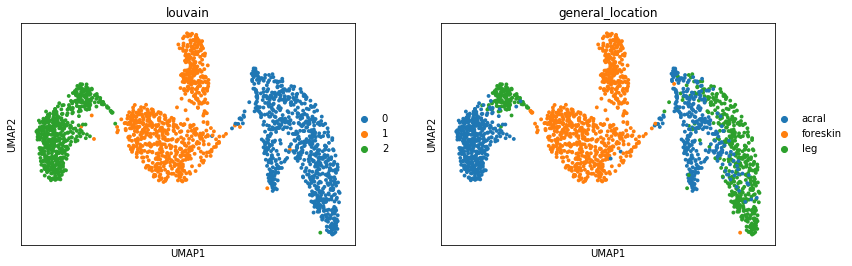

In [9]:
# DE gene tests
sc.pl.umap(adata_subset4, color=['louvain','general_location'])
ranks_df = simple_rank (adata_subset4, groupby='louvain', n_genes=10)
foreskin_test_genes = pd.merge(ranks_df[ranks_df.method == 'wilcoxon'].reset_index().rename(columns = {'index':'w'}).loc[:,['w','1']], 
         ranks_df[ranks_df.method == 't-test_overestim_var'].reset_index().rename(columns = {'index':'t'}).loc[:,['t','1']],
         'inner',
         '1').loc[:,'1'].values.tolist()

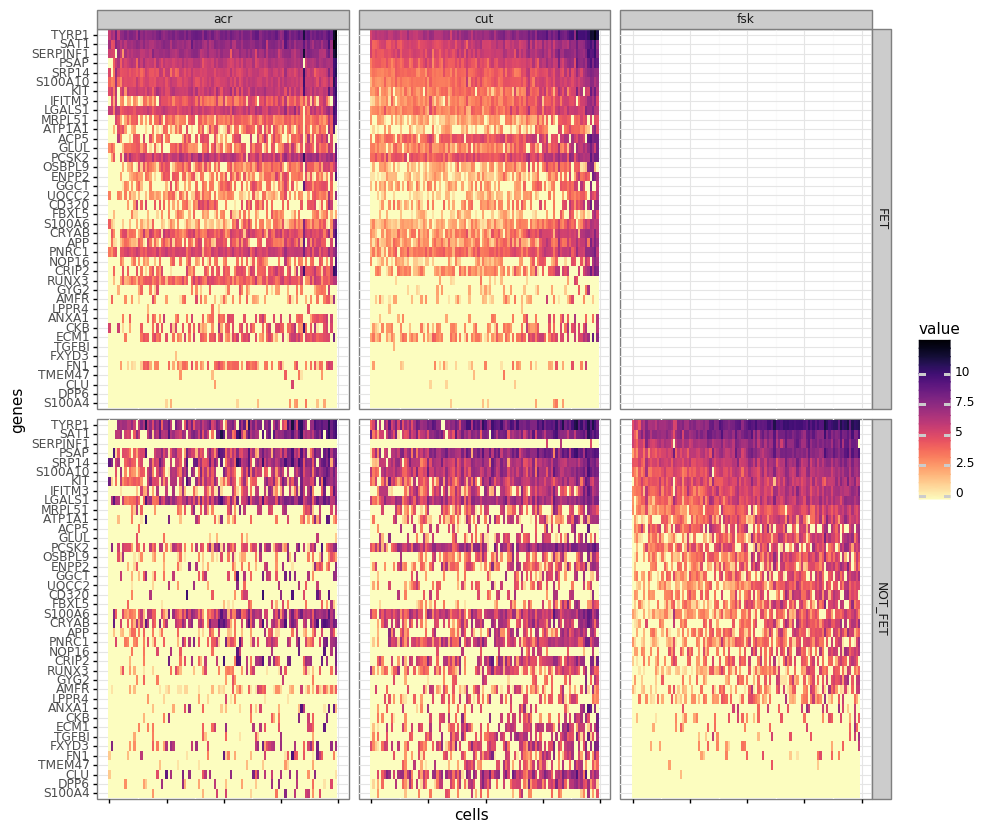

<ggplot: (8792233132857)>


In [14]:
# heat map of foreskin vs rest
input_adata = adata_subset2
subsampled_patients = []
canonical_genes = ['PMEL','MLANA','DCT','TYR','MITF','KIT','SOX10'] # ref all MEL lit
groupby_var = 'fsk'
cell_groups = 'cell_type'
pcOIs = [2,3]
pc_genes = (pca_genes_df[[x == groupby_var and y in pcOIs for x,y in zip(pca_genes_df['groupby'], 
                                                                         pca_genes_df['pc_idx'])]]
                 .genes
                 .values
                 .tolist())
genelist_df = pd.DataFrame({'genes':pc_genes})
genelist = genelist_df.drop_duplicates().genes.values.tolist()

return_df = pd.DataFrame()
for label in list(set(input_adata.obs[cell_groups])): # cell types
    for group in list(set(input_adata.obs.age_label)):
        try:
            slice_df = input_adata[[x == label and y == group for x,y in zip(input_adata.obs[cell_groups], 
                                                                             input_adata.obs.age_label)]]
            cells2keep = slice_df.obs.sample(100).index.tolist()
            slice_df = slice_df[[x in cells2keep for x in slice_df.obs.index.tolist()]]
            cat, genesOI_df = prepare_dataframe(slice_df,
                                                var_names = genelist,
                                                groupby='age_label')  
            genesOI_df = genesOI_df.reset_index() # recover groupby label
            genesOI_df[cell_groups] = label
            genesOI_df['row_mean'] = genesOI_df.mean(axis = 1)
            genesOI_df = genesOI_df.sort_values('row_mean')
            genesOI_df['index'] = [x for x in range(len(genesOI_df))]
            return_df = return_df.append(genesOI_df.drop('row_mean', axis = 1))
        except:
            pass

plot_df = pd.melt(return_df, id_vars=['index','age_label',cell_groups])
target_gene_order = (plot_df[plot_df[cell_groups] == groupby_var]
                     .groupby('variable')
                     .mean()
                     .sort_values('value')
                     .index
                     .tolist())
plot_df['variable'] = plot_df['variable'].astype(str).astype(CategoricalDtype(target_gene_order, ordered=True))

plotnine.options.figure_size = (10,10)
print(ggplot(plot_df)
      +theme_bw()
      +theme(panel_spacing = 0.1,
            axis_text_x = element_blank())
     +geom_tile(aes('index','variable',fill='value'))
     +scale_fill_cmap('magma_r')
     +facet_grid(f'age_label~{cell_groups}', scales='free')
     +labs(x='cells',y='genes'))

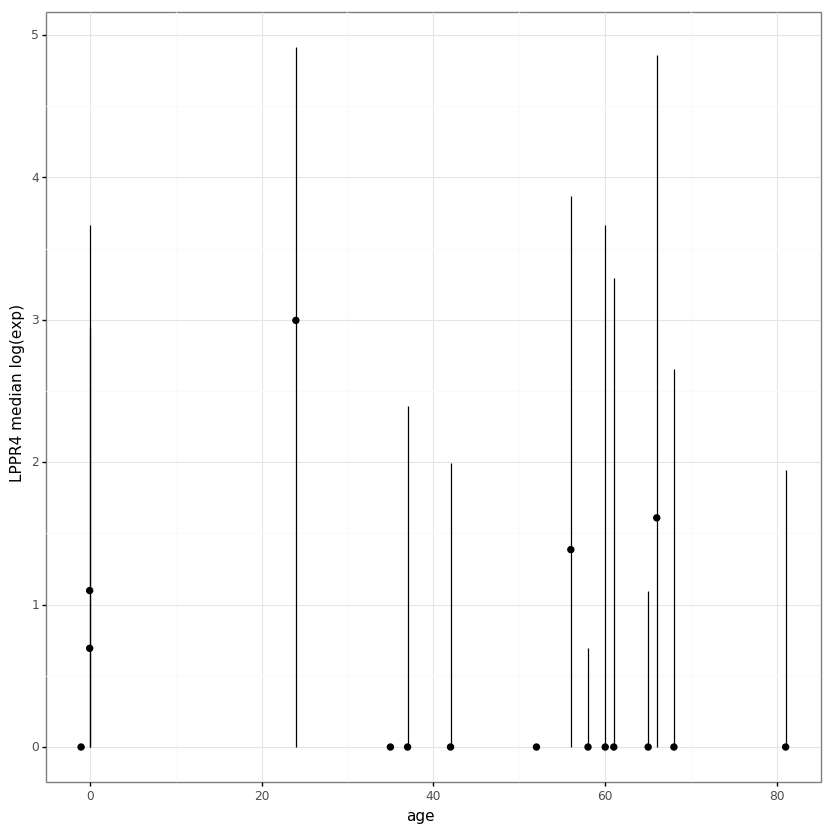

<ggplot: (8792156517654)>


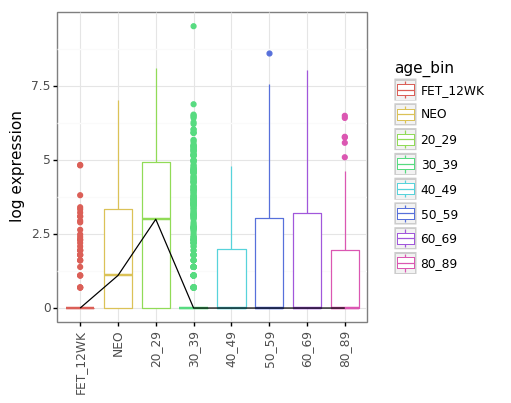

<ggplot: (-9223363244632885658)>


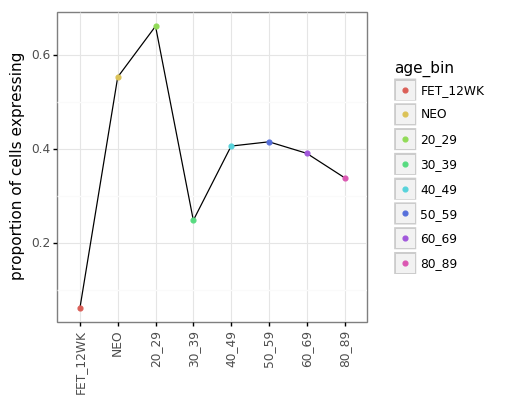

<ggplot: (8792291626539)>


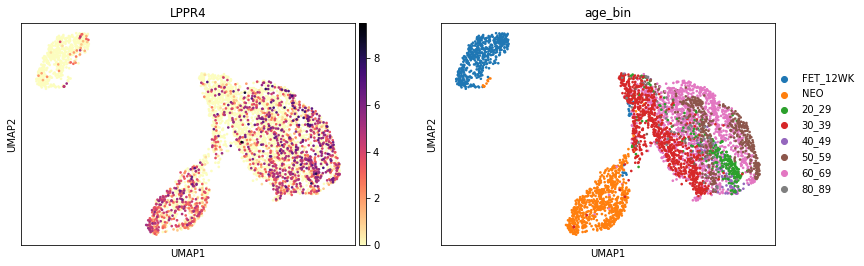

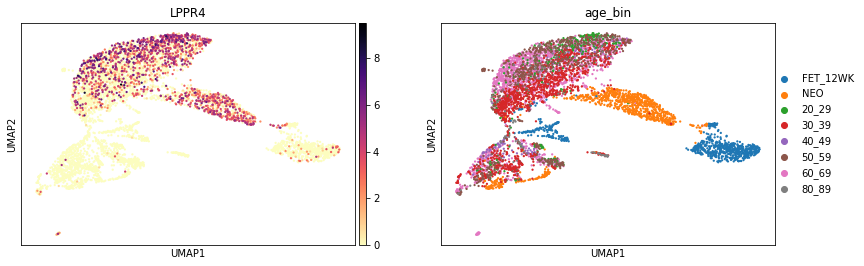

querying 1-1...done.
Finished.
1 input query terms found no hit:
	['LPPR4']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0:  LPPR4 
 N/A


In [15]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'LPPR4'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_bin'

###############################################

# true age
true_age_exp(gene, input_adata)

# binned age
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]